In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from classes import Bandpasses, LightCurve

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

In [3]:
# load the LSST bandpasses
bandpasses = Bandpasses()

### SNe types and LSST filters

In [58]:
data_loc = 'plasticc_data/'
file_dict = {'SNIa':'SNIa_SkyObjects.pkl', 'SNII-1':'SNII_SkyObjects.pkl', 
             'SNII-2':'SNII_SkyObjects.pkl', 'SNII-3':'SNII_SkyObjects.pkl',
             'SNIbc':'SNIbc_SkyObjects.pkl'}

pmin_dict = {'SNIa':-20, 'SNII-1':-24, 'SNII-2': -5, 'SNII-3':-20, 'SNIbc':-25}
pmax_dict = {'SNIa': 80, 'SNII-1':100, 'SNII-2':120, 'SNII-3': 90, 'SNIbc':100}

color_dict = {'lsstu':'C4', 'lsstg':'C2', 'lsstr':'C3', 'lssti':'C1', 'lsstz':'gray', 'lssty':'k'}

### Load the data

In [59]:
sne_dict = dict()
lc_dict = dict() # will be filled later
tset_dict = dict() # will be filled later

for snType,file in file_dict.items():
    
    # keep only data point in the phase range (tmin,tmax)
    pmin = pmin_dict[snType]
    pmax = pmax_dict[snType]
    
    # keep only fluxes with ferr <= ferr_cut
    ferr_cut = 0.05
    
    with open(data_loc + file_dict[snType], 'rb') as input:
        
        sne = []
        for sn in pickle.load(input):
            phase = sn.photometry['mjd'] - sn.t0
            sn.photometry = sn.photometry[(phase >= pmin) & (phase <= pmax)]
            sn.photometry = sn.photometry[np.abs(sn.photometry['flux_err']/sn.photometry['flux']) <= ferr_cut]    
            if len(sn.photometry) > 0 and sn.source == snType:
                sne.append(sn)
        print(f'{snType:<7}:{len(sne):>5}')
        sne_dict[snType] = sne

SNIa   : 6118
SNII-1 : 1513
SNII-2 : 3284
SNII-3 :  214
SNIbc  :  726


### Functions

In [60]:
def learn_lc(snType, pstep=1, wstep=100, w=1, dmse_stop=0.05, Ncpus=8):
    
    print(snType)

    # create the initial null lightcurve
    pmin = pmin_dict[snType]
    pmax = pmax_dict[snType]
    phase = np.arange(pmin, pmax + pstep, pstep)
    wavelen = np.arange(1700, 12100, 100)
    lc = LightCurve(phase, wavelen)
    lc.null()
    
    # get the supernovae
    sne = sne_dict[snType]

    # create the training sets
    training_sets = lc.training_sets(sne)

    # list empty training sets
    empty_sets = [p for p,val in training_sets.items() if len(val) == 0]
    if len(empty_sets) > 0:
        print(f'The following training sets are empty:{empty_sets}')
        print('Removing those time slices')
    
        # remove all the empty time slices
        for p in empty_sets:
            phase = np.delete(phase, np.where(phase == p))
            del training_sets[p]
        lc = LightCurve(phase, wavelen)
        lc.null()

    # calculate the initial wMSE
    mse0 = lc.mse(training_sets, bandpasses, Ncpus=Ncpus)
    print(f'mse0: {mse0:.2f}')

    # train the lightcurve
    lc.train(training_sets, bandpasses, w=w, dmse_stop=dmse_stop, Ncpus=Ncpus)  

    # calculate final wMSE
    msef = lc.mse(training_sets, bandpasses, Ncpus=Ncpus)
    print(f'msef: {msef:.2f}')
    
    # calculate fractional change in wMSE
    print(f'dmse: {(msef-mse0)/mse0:.2f}')
    
    tset_dict[snType] = training_sets
    lc_dict[snType] = lc

def plot_photometry(snType):
    
    fig,ax = plt.subplots()
    
    sne = sne_dict[snType]
    pmin = pmin_dict[snType]
    pmax = pmax_dict[snType]
    
    for sn in sne:
        phase = (sn.photometry['mjd'] - sn.t0)/(1 + sn.specz)
        fluxes = sn.photometry['flux']
        colors = [color_dict[band] for band in sn.photometry['filter']]
        plt.scatter(phase, fluxes, c=colors, marker='.', s=0.5)
        
    ax.set_xlabel('Phase (Days)')
    ax.set_ylabel('Flux Density')
    ax.set_xlim(pmin - 5, pmax + 5)
    
    for name,c in color_dict.items():
        ax.scatter([pmin - 10], [1], c=c, label=name, marker='o')
    ax.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)
    
    ax.text(0.9, 0.8, snType, transform=ax.transAxes, ha='right', va='top')

def plot_trained_pslice(snType, phase):
    
    lc = lc_dict[snType]
    tset = tset_dict[snType][phase]
    
    fig,ax = plt.subplots()
    
    sed = lc.sed_slice(phase)
    ax.plot(sed.wavelen, sed.flambda, lw=2, alpha=1)
    
    for sn in tset:
        filters = sn.photometry['filter']
        wavelen = bandpasses.mean_wavelens(filters)/(1 + sn.specz)
        fluxes = sn.photometry['flux']
        fluxerrs = sn.photometry['flux_err']
        colors = [color_dict[band] for band in filters]
        plt.errorbar(wavelen, fluxes, fluxerrs, c=colors, linestyle='None')
        
    for name,c in color_dict.items():
        ax.scatter([-10], [-10], c=c, label=name)
    ax.legend(ncol=3, fontsize='small', loc='upper right', columnspacing=0, handletextpad=0)

    ax.text(0.9, 0.8, f't = {phase}', transform=ax.transAxes, ha='right', va='top')

    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
    ax.set_ylabel('Flux Density')
    ax.set_xlim(1700, 12000)
    ax.set_ylim(0,None)
    
def plot_phase_profile(snType, phase, pstep=0.5):
    
    tset = tset_dict[snType][phase]
    
    offset_dict = {'lsstu':0, 'lsstg':1, 'lsstr':2, 'lssti':3, 'lsstz':4, 'lssty':5}
    
    fig,ax = plt.subplots()
    
    for sn in tset:
        
        filters = sn.photometry['filter']
        wavelen = bandpasses.mean_wavelens(filters)/(1 + sn.specz)
        phases = (sn.photometry['mjd'] - sn.t0)/(1 + sn.specz)
        phases = [p + pstep*offset_dict[filters[i]] for i,p in enumerate(phases)]
        colors = [color_dict[band] for band in sn.photometry['filter']]
        ax.scatter(wavelen, phases, c=colors)
    
    ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
    ax.set_ylabel("Phase (Days) + Offset")
    
    ax.set_yticks([])
    ax.hlines(pstep*np.array(list(offset_dict.values())) + phase, 2500, 9000, alpha=0.15)
    
def plot_redshift_profile(snType, phase):
    
    tset = tset_dict[snType][phase]
    
    offset_dict = {'lsstu':0, 'lsstg':1, 'lsstr':2, 'lssti':3, 'lsstz':4, 'lssty':5}
    
    fig,ax = plt.subplots()
    
    for sn in tset:
        
        filters = sn.photometry['filter']
        wavelen = bandpasses.mean_wavelens(filters)/(1 + sn.specz)
        redshift = sn.specz * np.ones(len(wavelen))
        colors = [color_dict[band] for band in sn.photometry['filter']]
        ax.scatter(wavelen, redshift, c=colors)
    
    ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
    ax.set_ylabel("Redshift")
    
def plot_distmod_profile(snType, phase):
    
    tset = tset_dict[snType][phase]
    
    fig,ax = plt.subplots()
    
    for sn in tset:
        
        filters = sn.photometry['filter']
        wavelen = bandpasses.mean_wavelens(filters)/(1 + sn.specz)
        distmod = sn.distmod * np.ones(len(wavelen))
        colors = [color_dict[band] for band in sn.photometry['filter']]
        ax.scatter(wavelen, distmod, c=colors)
    
    ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
    ax.set_ylabel("Distance Modulus")

### SNIa

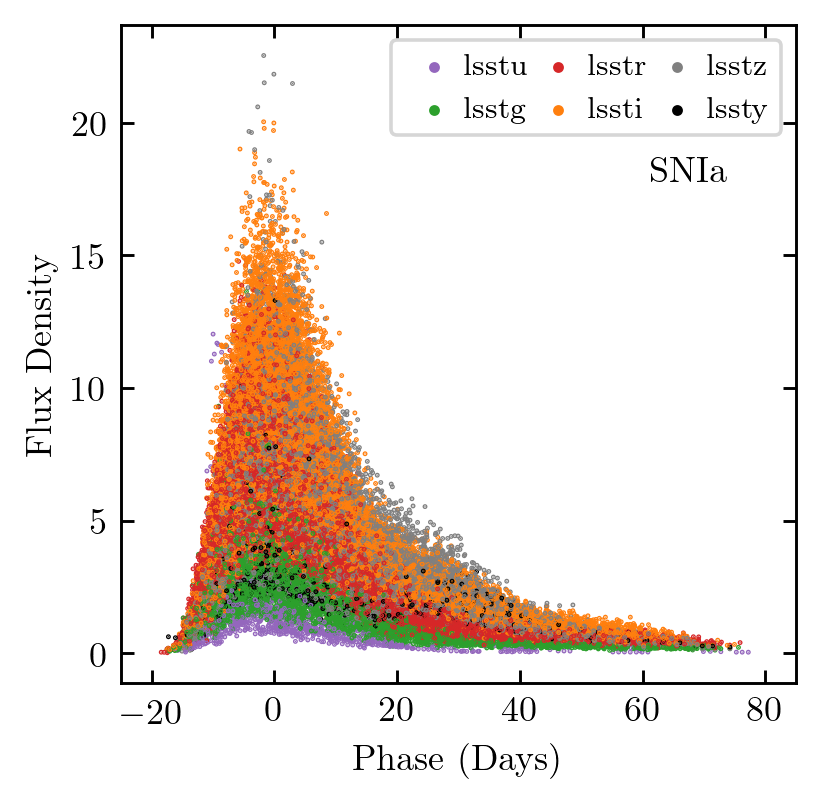

In [9]:
plot_photometry('SNIa')

In [10]:
learn_lc('SNIa')

SNIa
The following training sets are empty:[-20, -19, 78, 79, 80]
Removing those time slices
mse0: 101762.93
msef: 7660.82
dmse: -0.92


In [7]:
learn_lc('SNIa')

SNIa
mse0: 103495.66
msef: 8854.06
dmse: -0.91


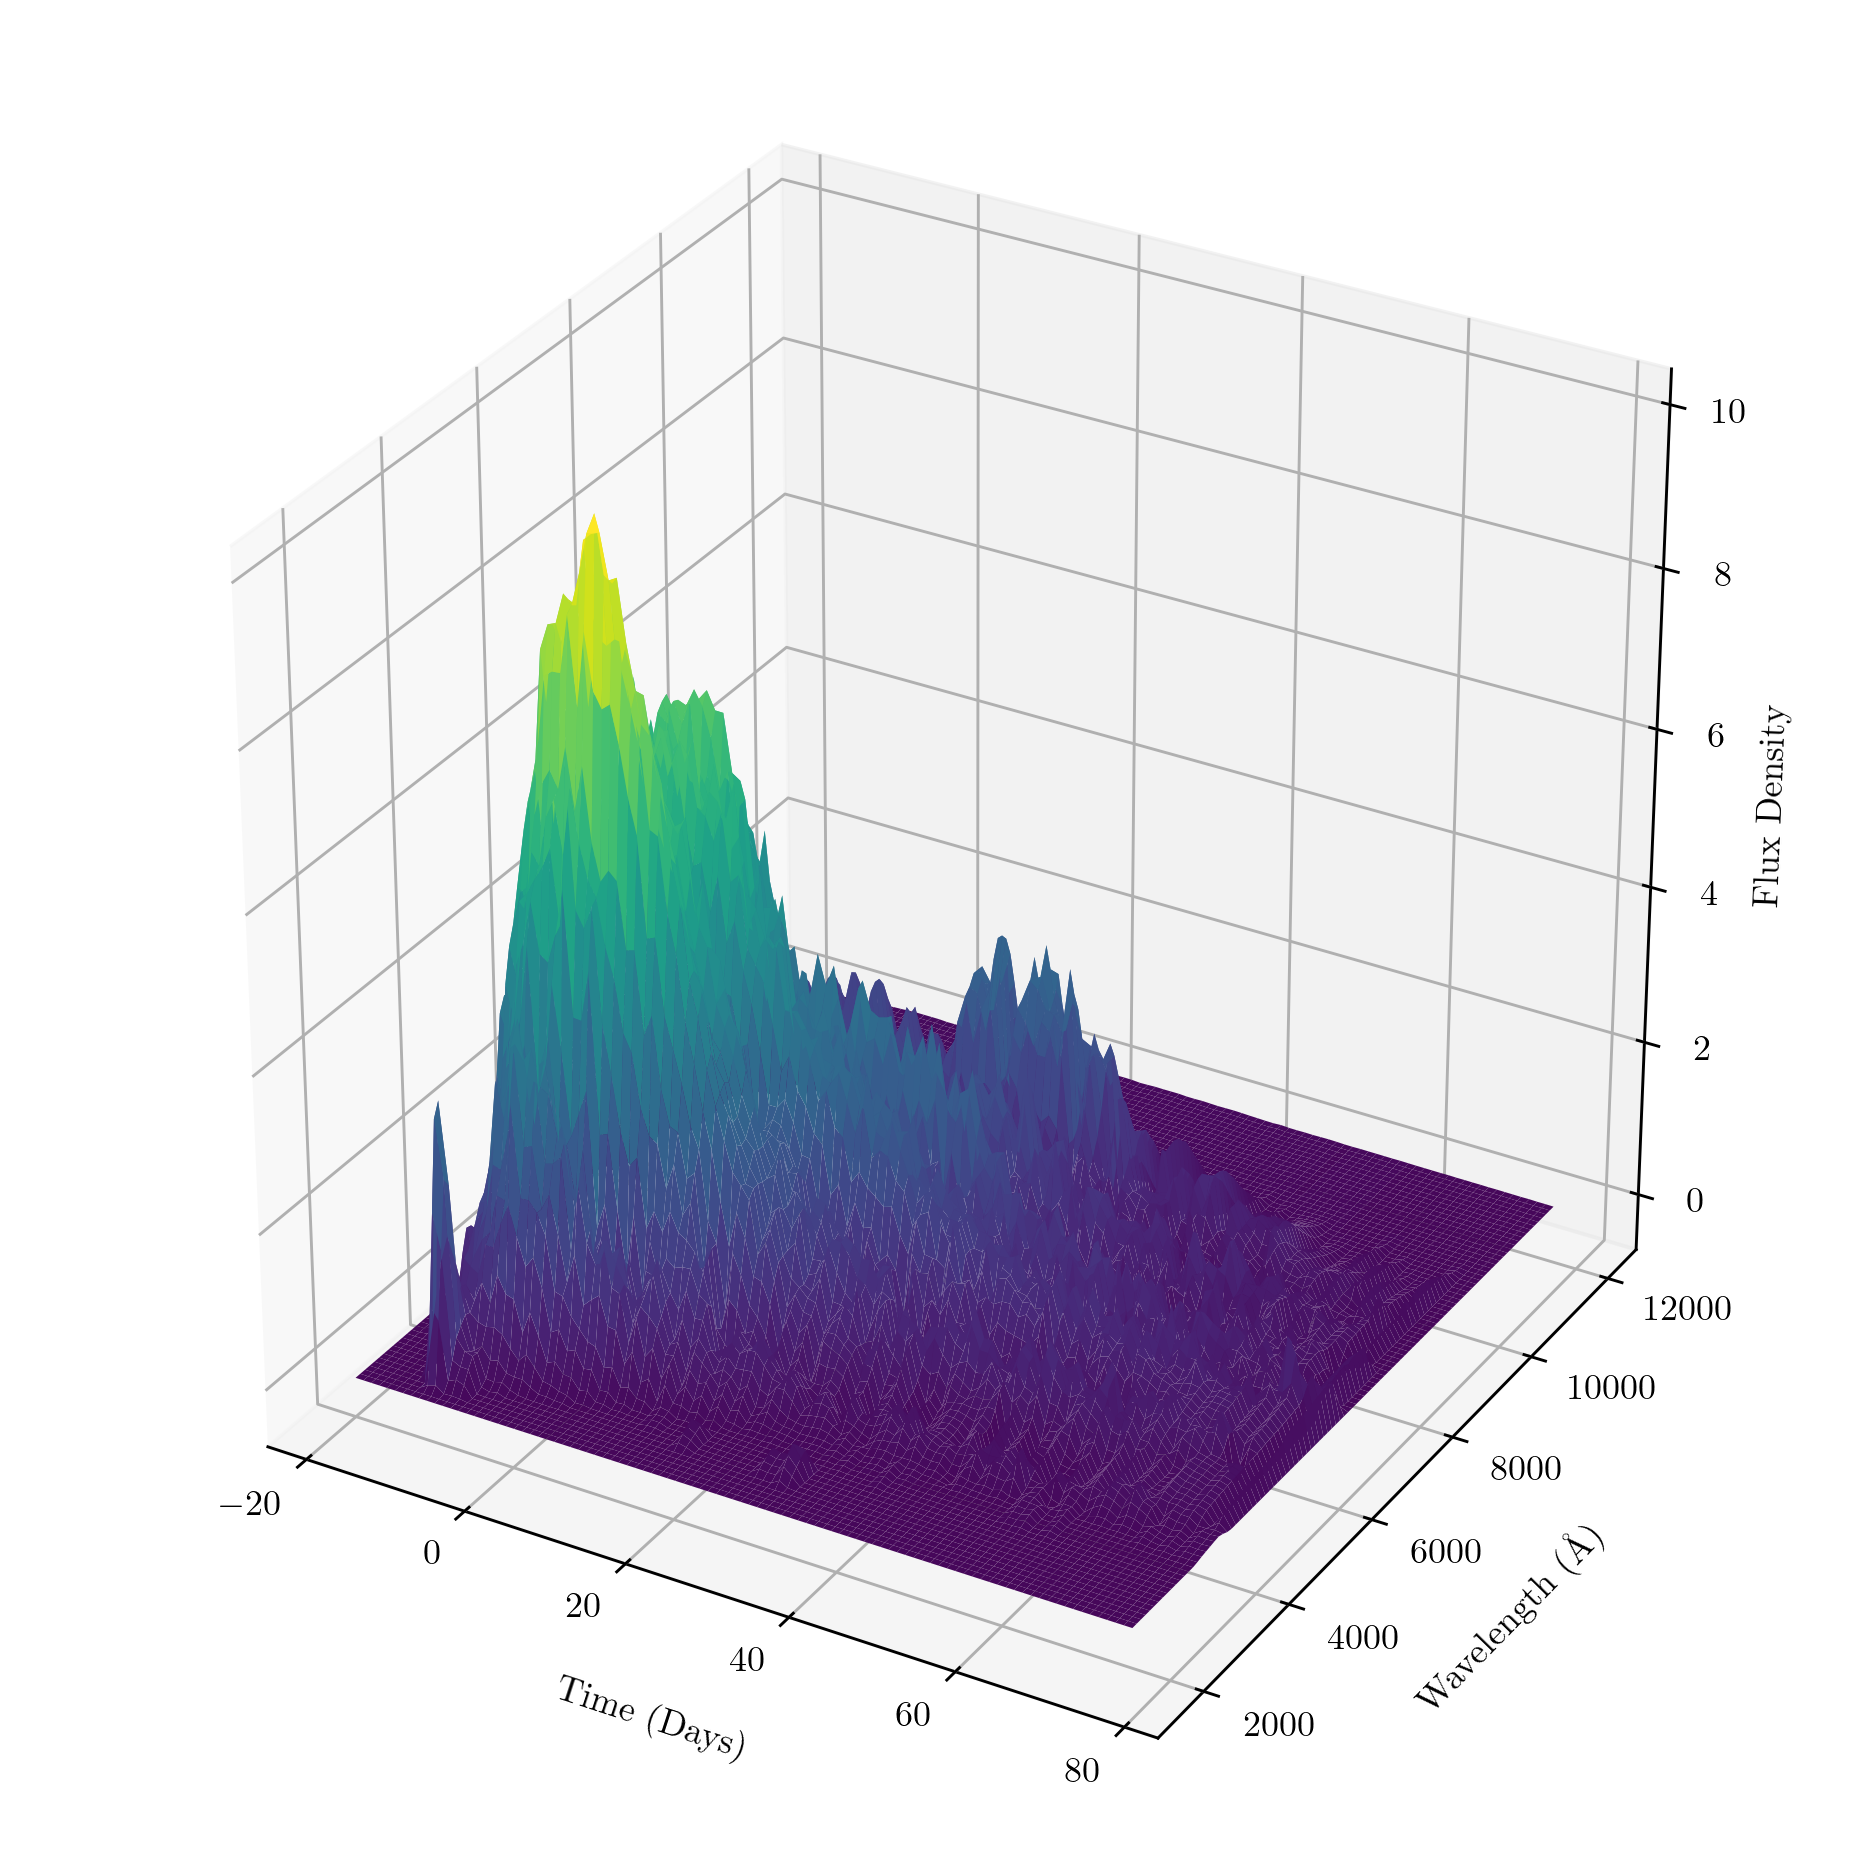

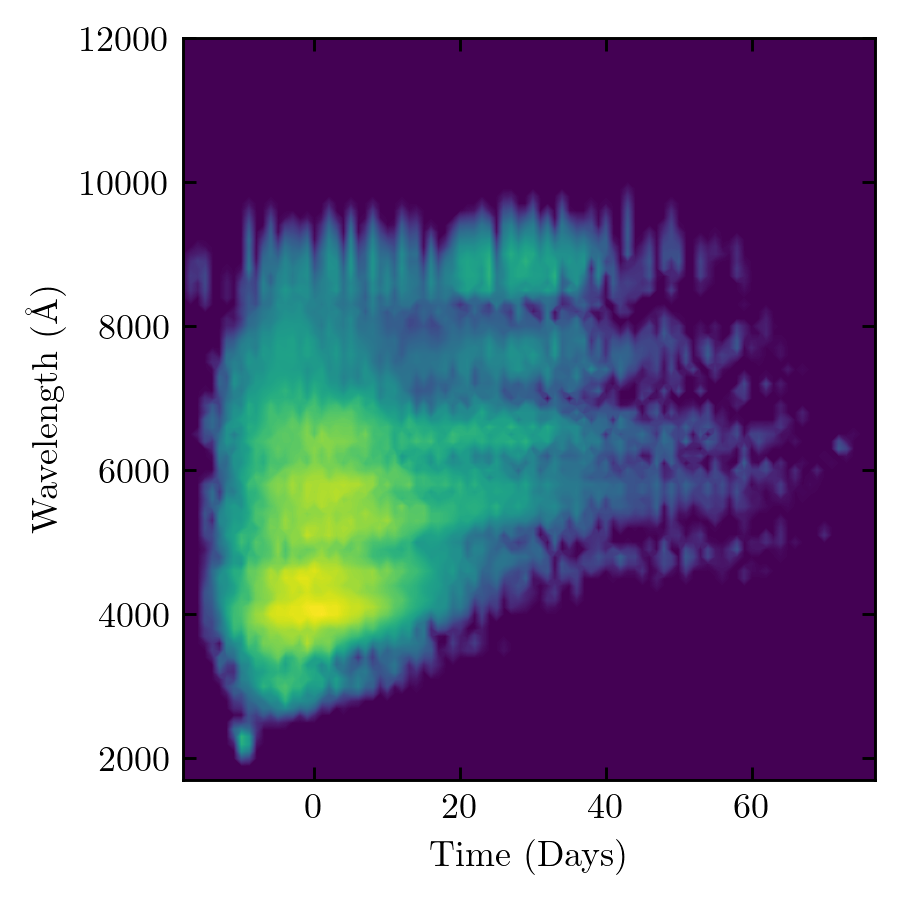

In [11]:
lc = lc_dict['SNIa']
lc.surface_plot()
lc.contour_plot()
plt.show()

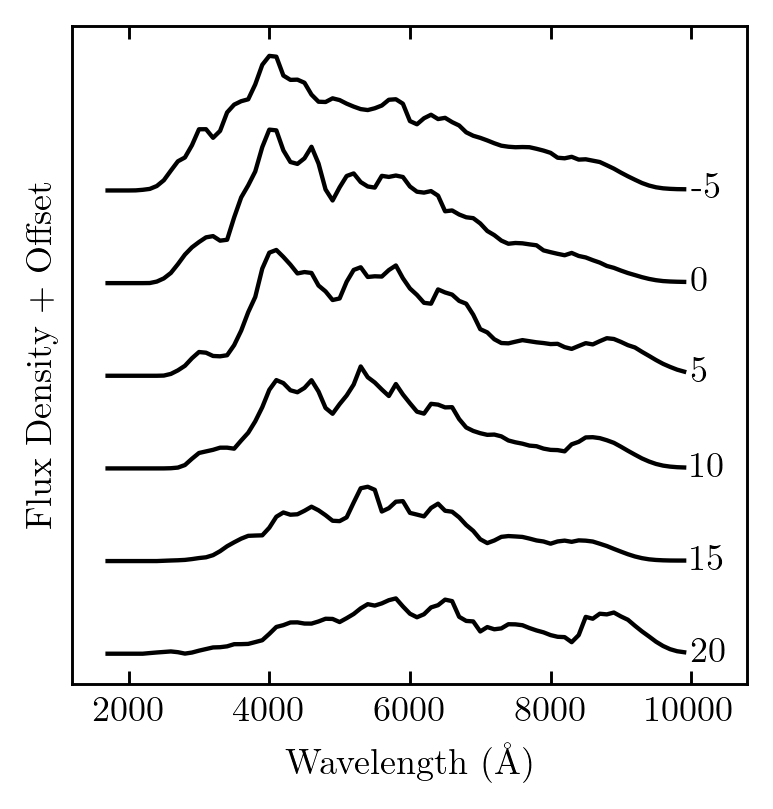

In [12]:
trange = [-5,0,5,10,15,20]
lc.stacked_plot(trange, offset_scale=6)
plt.show()

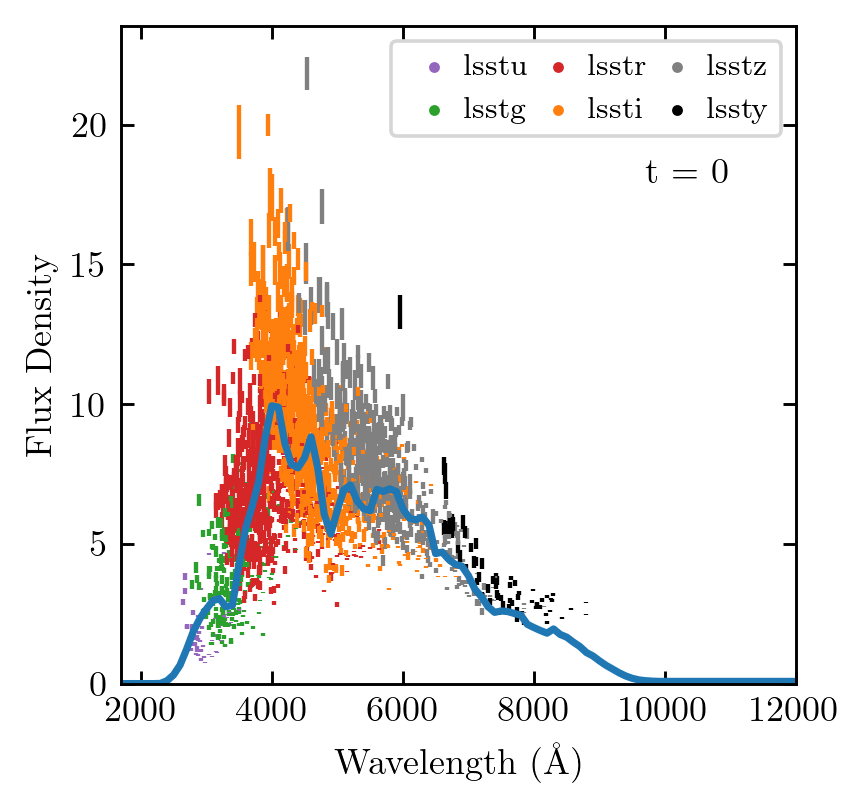

In [14]:
plot_trained_pslice('SNIa', 0)

### SNII-2 (SNII-NMF)

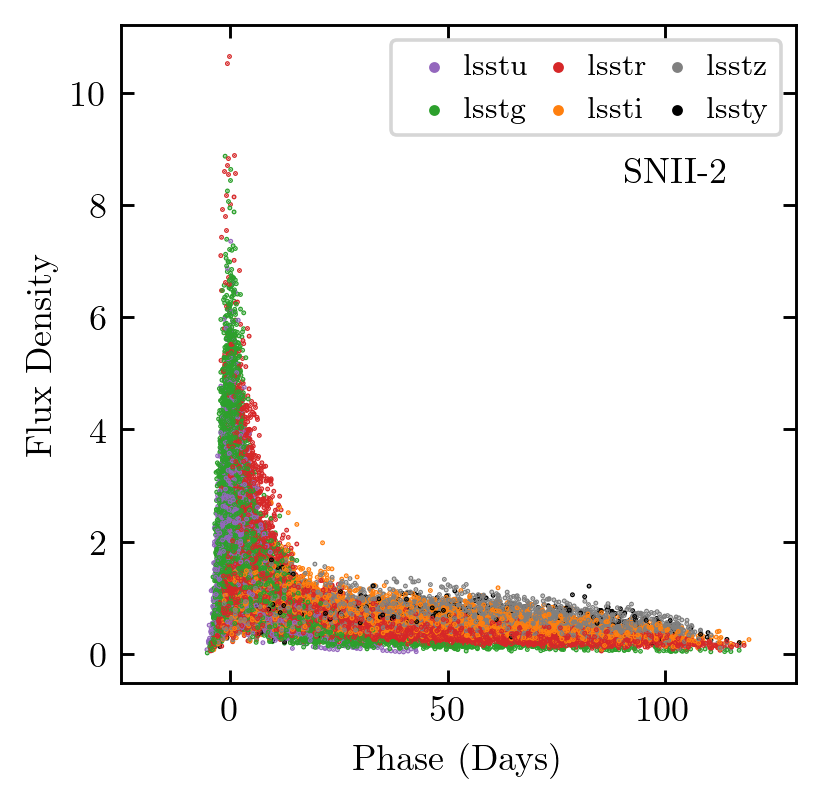

In [61]:
plot_photometry('SNII-2')

In [17]:
learn_lc('SNII-2', pstep=2, w=3)

SNII-2
The following training sets are empty:[-8, 146, 148, 150, 152, 154, 156]
Removing those time slices
mse0: 4529.08
msef: 561.17
dmse: -0.88


In [8]:
learn_lc('SNII-2', tstep=2, w=3)

SNII-2
The following training sets are empty:[-8, 156]
Removing those time slices
mse0: 4529.08
msef: 586.80
dmse: -0.87


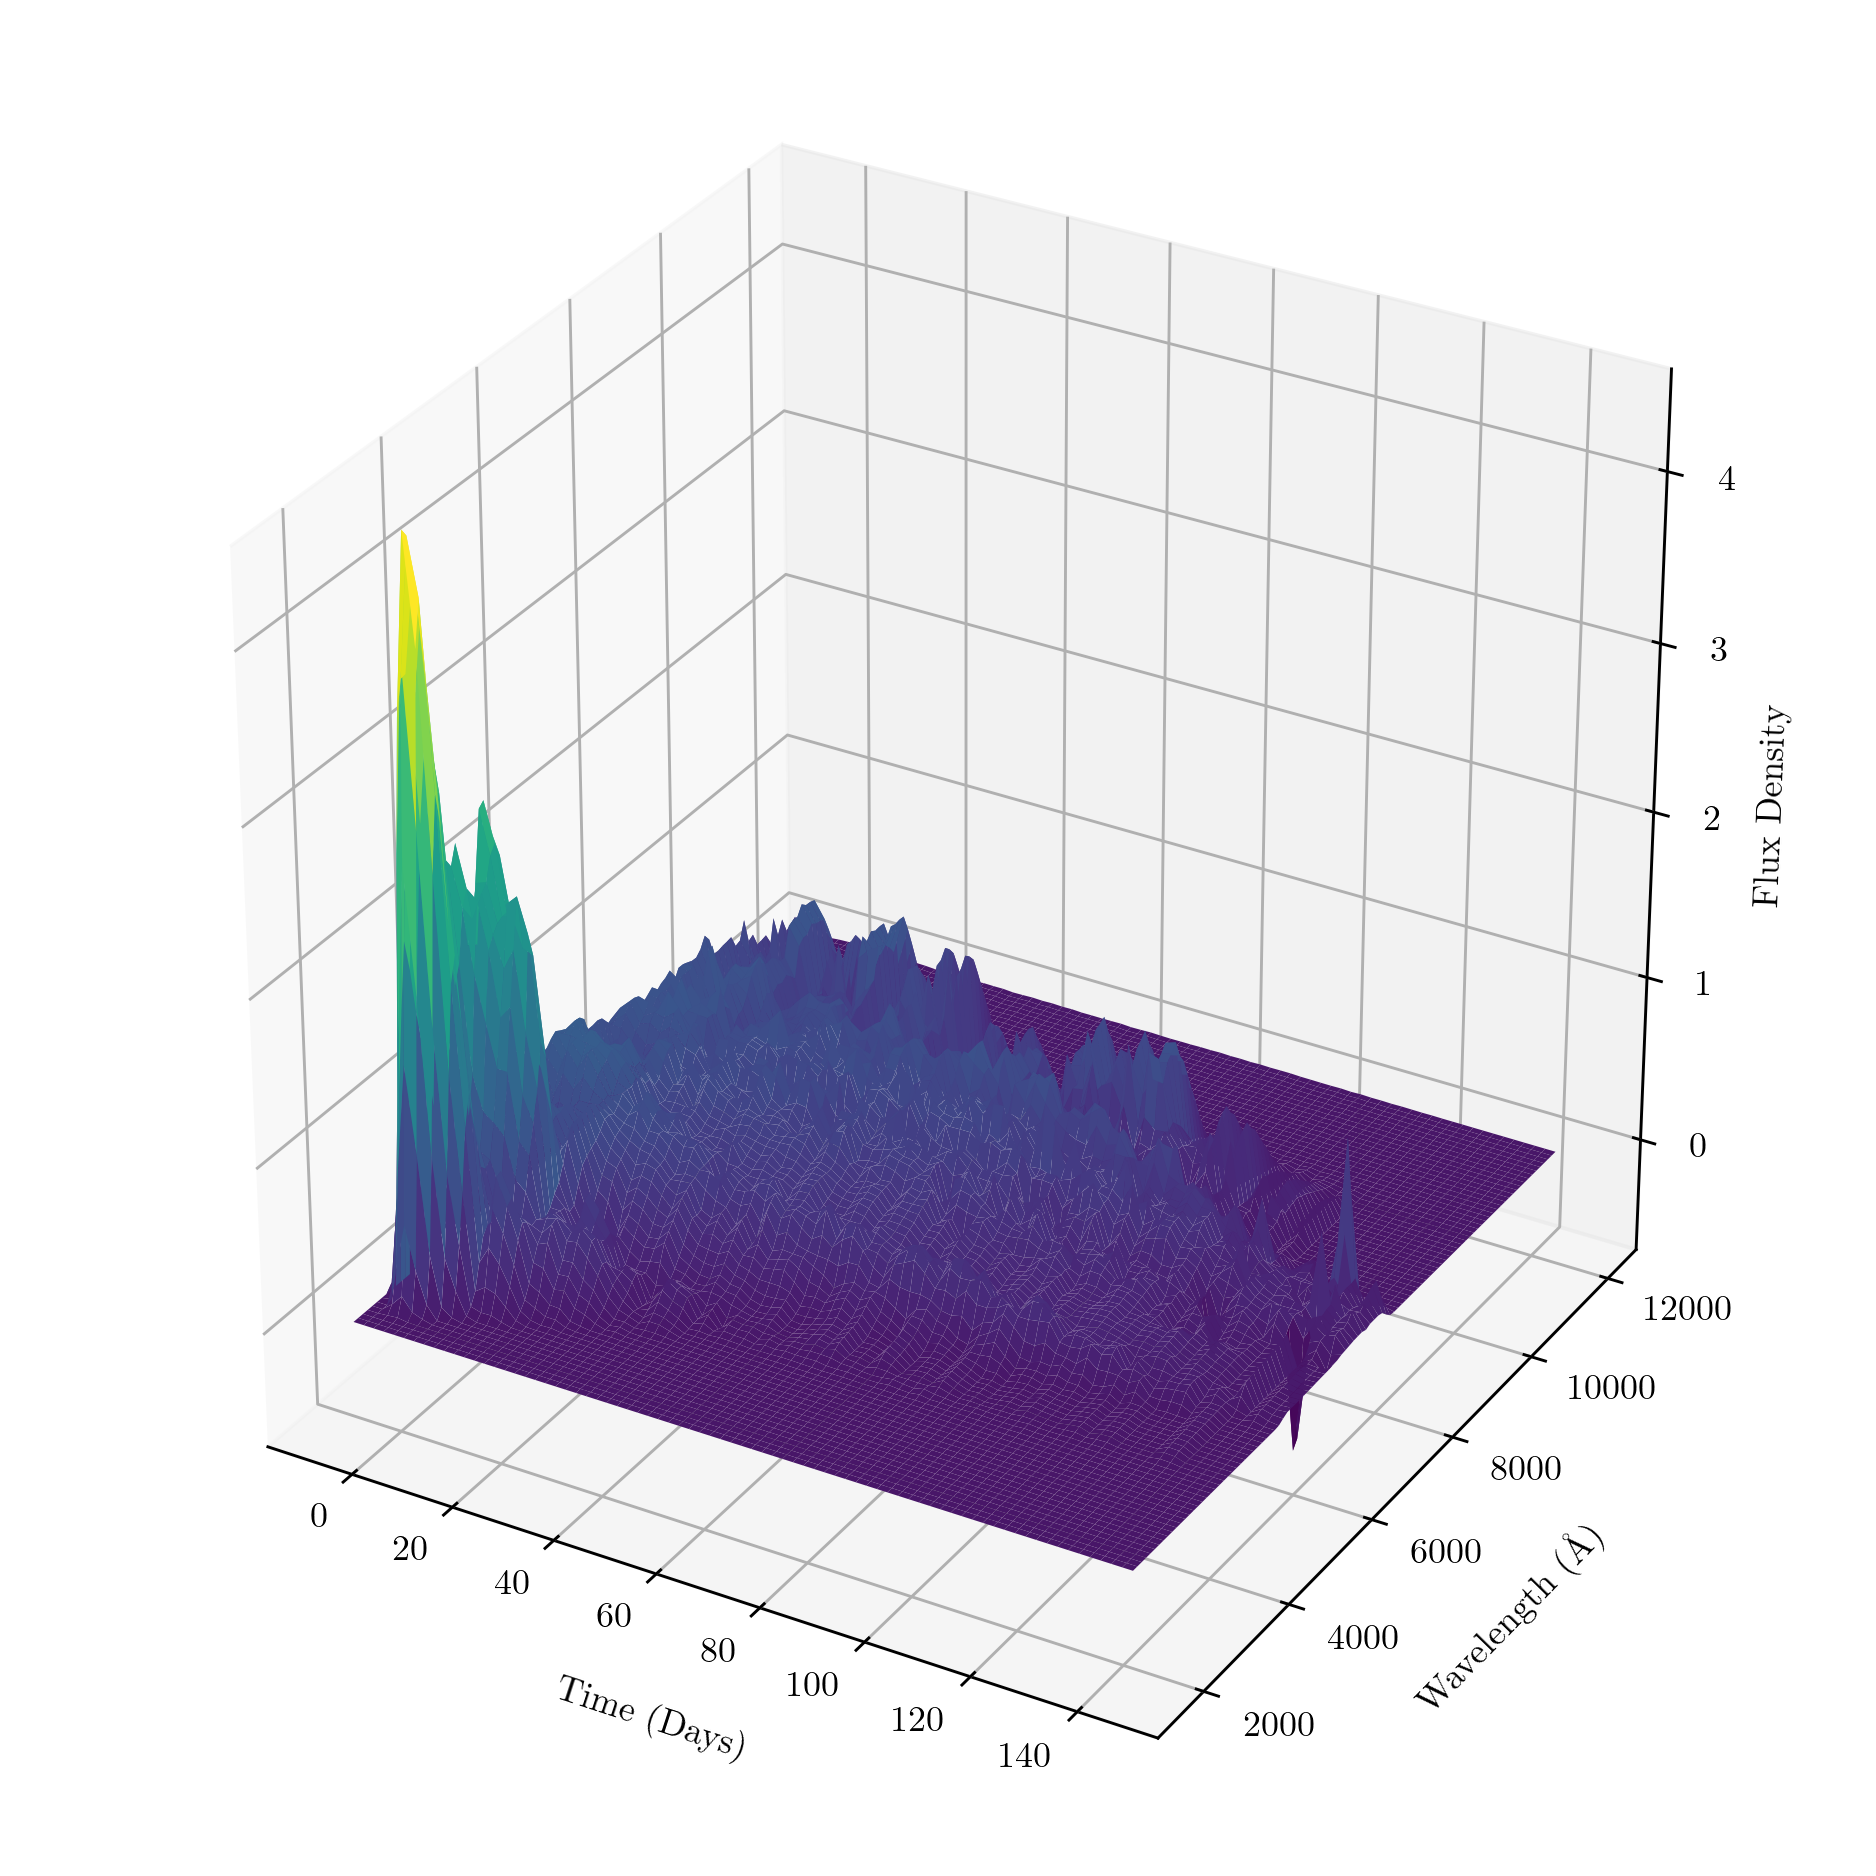

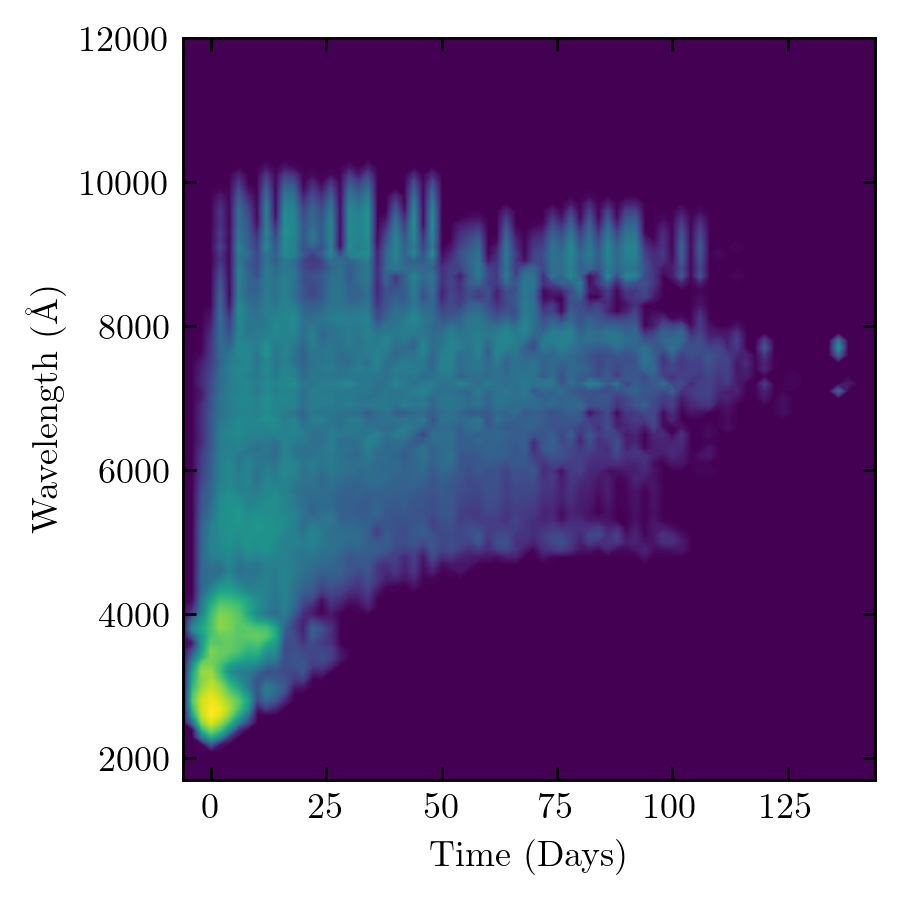

In [18]:
lc = lc_dict['SNII-2']
lc.surface_plot()
lc.contour_plot()
plt.show()

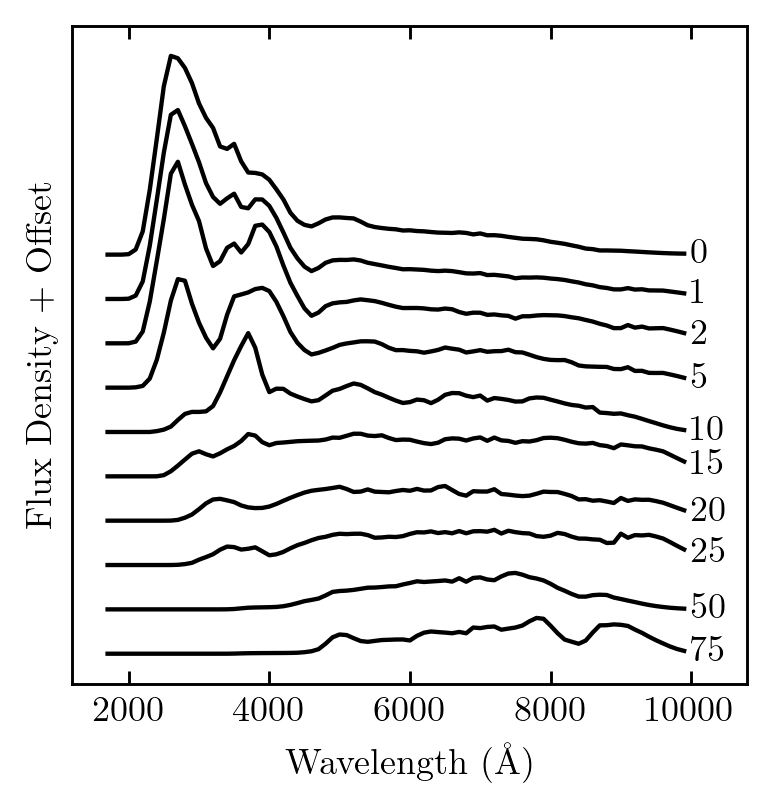

In [19]:
trange = [0,1,2,5,10,15,20,25,50,75]
lc.stacked_plot(trange)
plt.show()

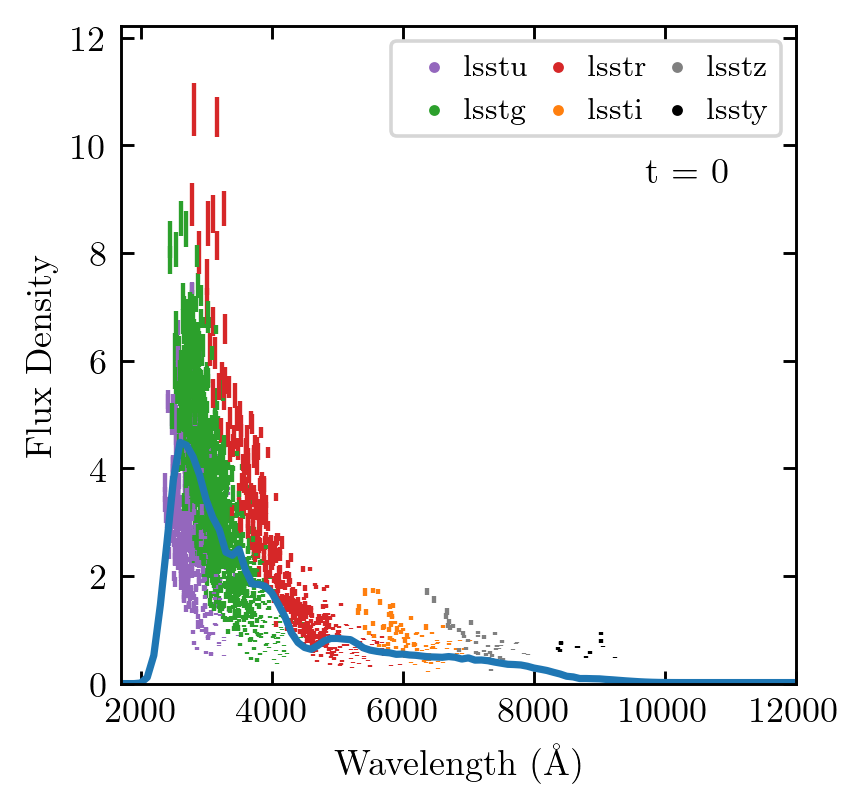

In [32]:
plot_trained_pslice('SNII-2', 0)

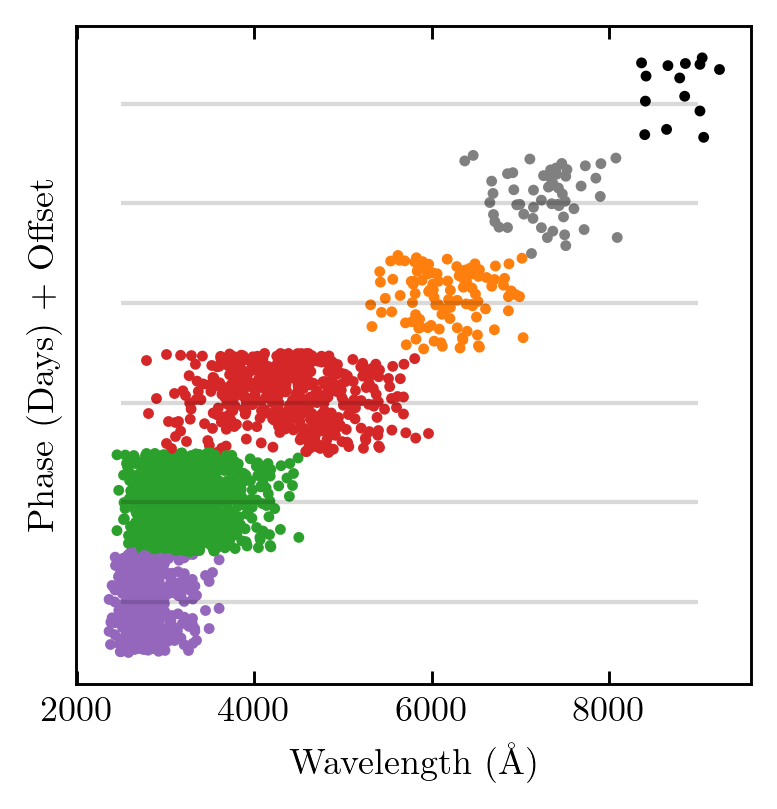

In [22]:
plot_phase_profile('SNII-2', 0, 2)

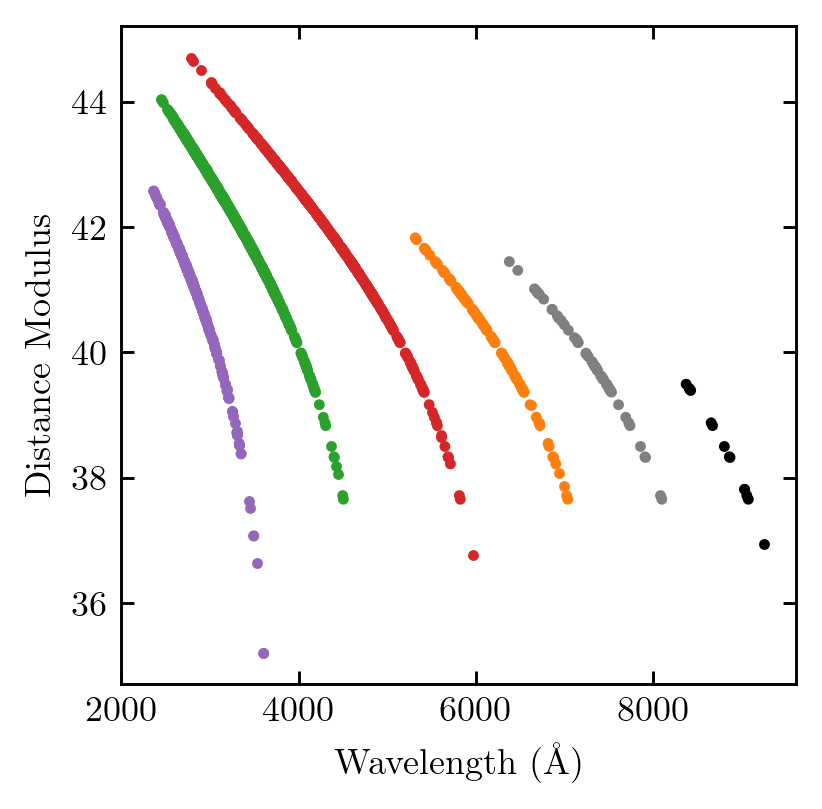

In [23]:
plot_distmod_profile('SNII-2', 0)

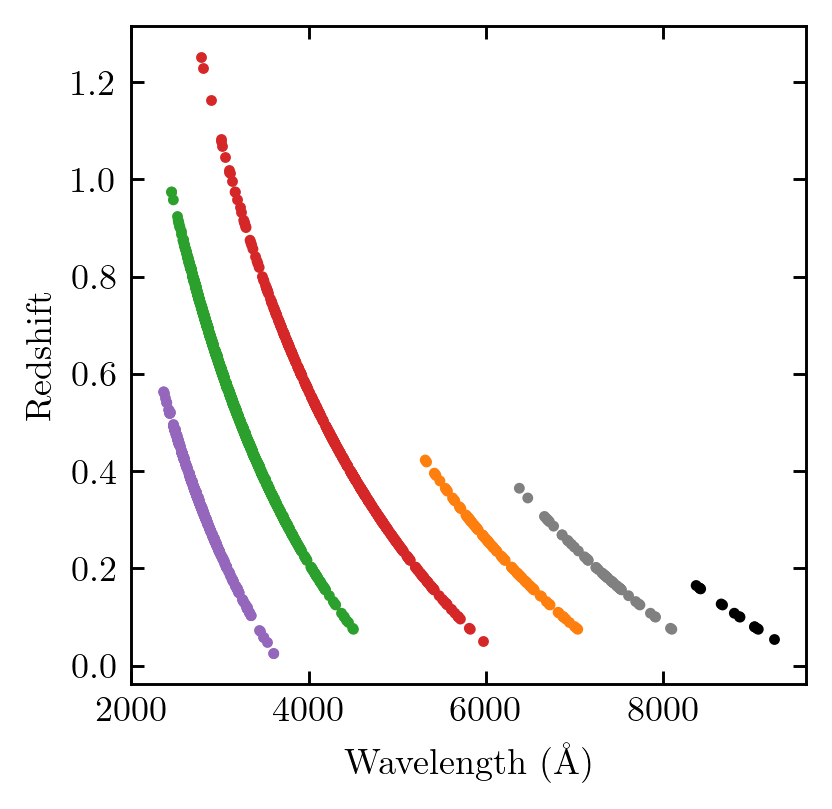

In [24]:
plot_redshift_profile('SNII-2', 0)

### SNIbc

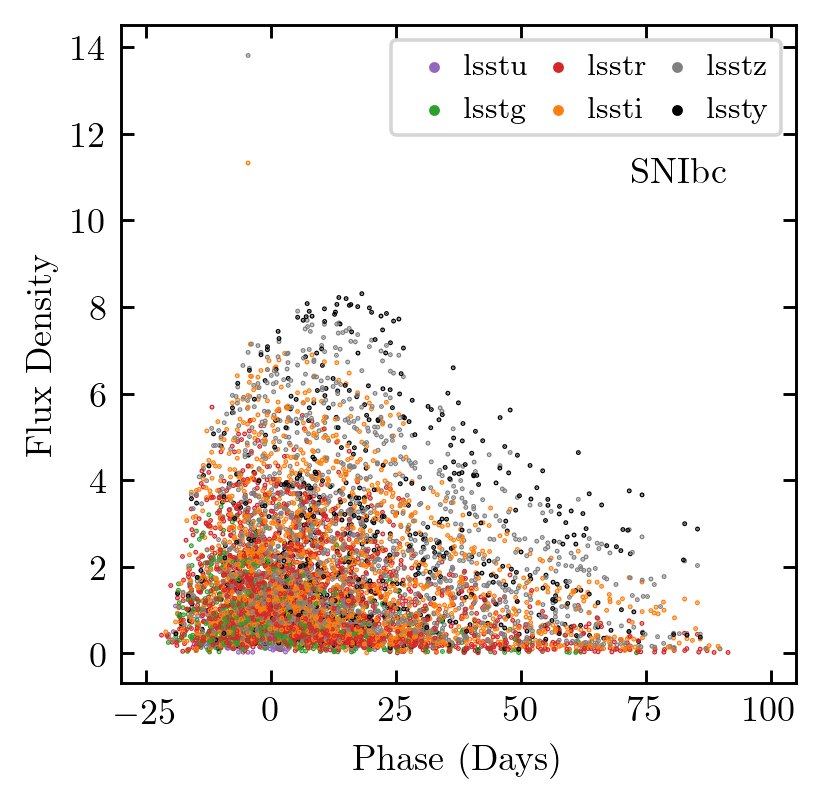

In [62]:
plot_photometry('SNIbc')

In [24]:
learn_lc('SNIbc', tstep=2, w=3)

SNIbc
mse0: 23492.97
msef: 8125.35
dmse: -0.65


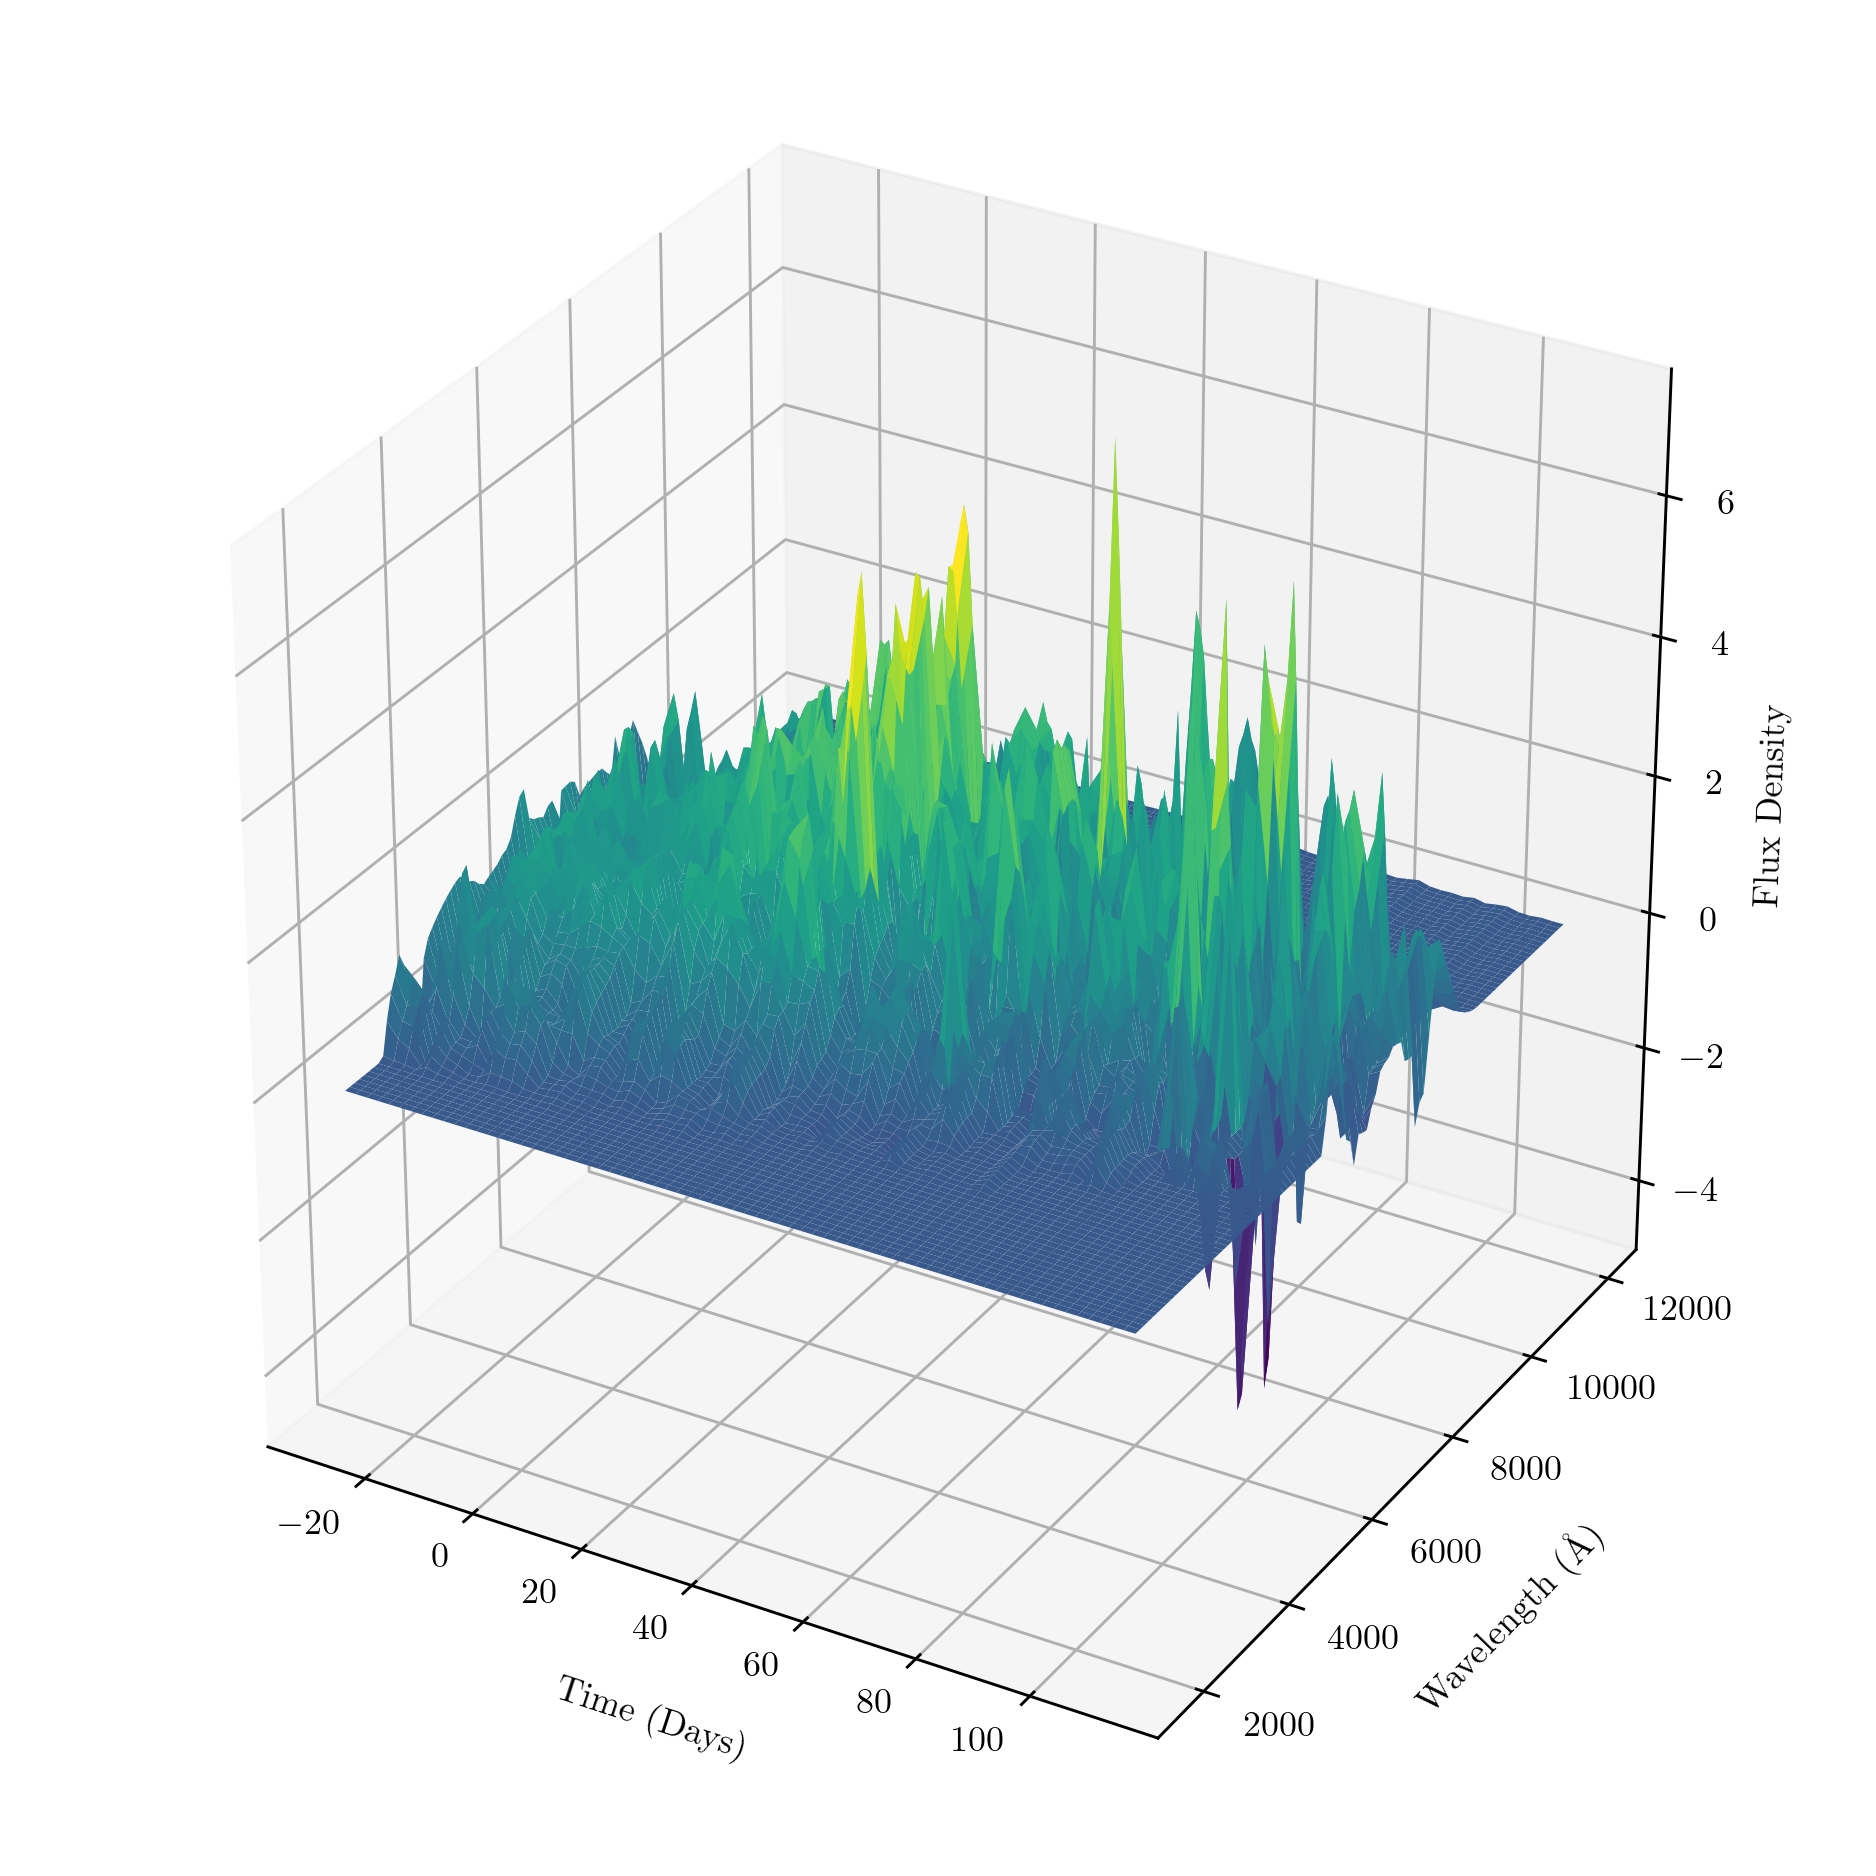

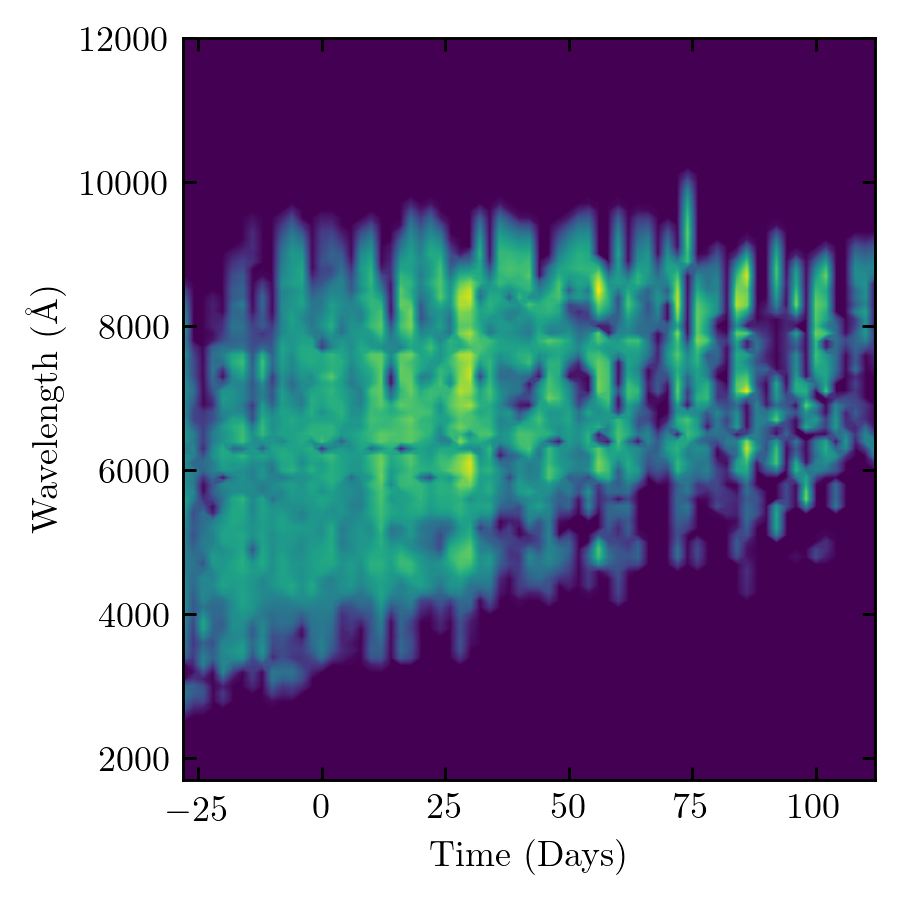

In [25]:
lc = lc_dict['SNIbc']
lc.surface_plot()
lc.contour_plot()
plt.show()

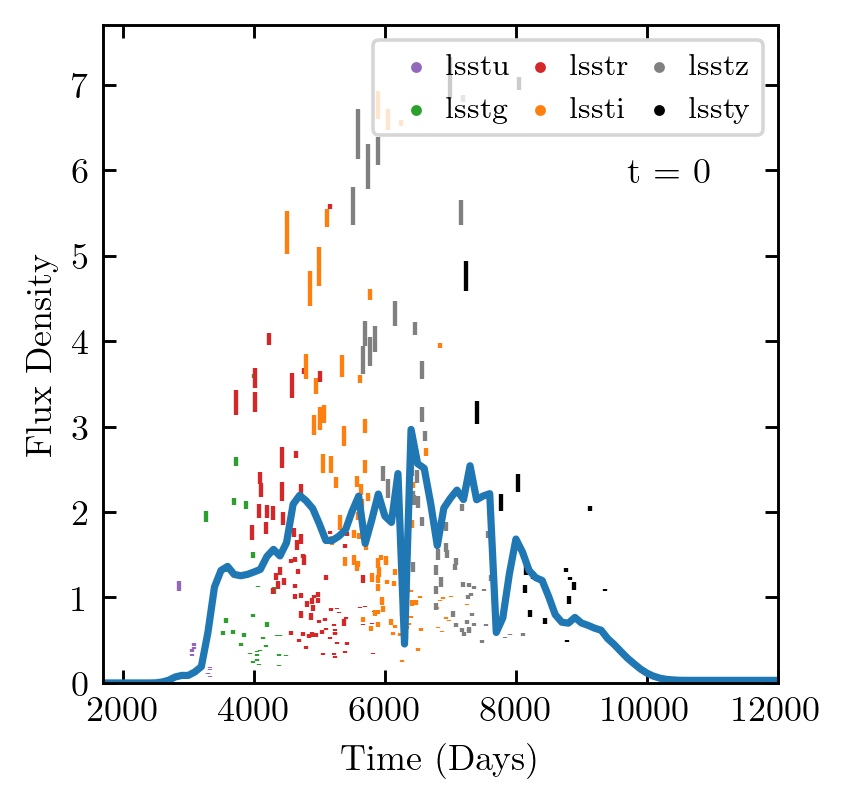

In [26]:
plot_trained_tslice('SNIbc', 0)

# Below

are two different simulations of SNII that I haven't figured out yet 

### SNII-1 (SNII-Templates)

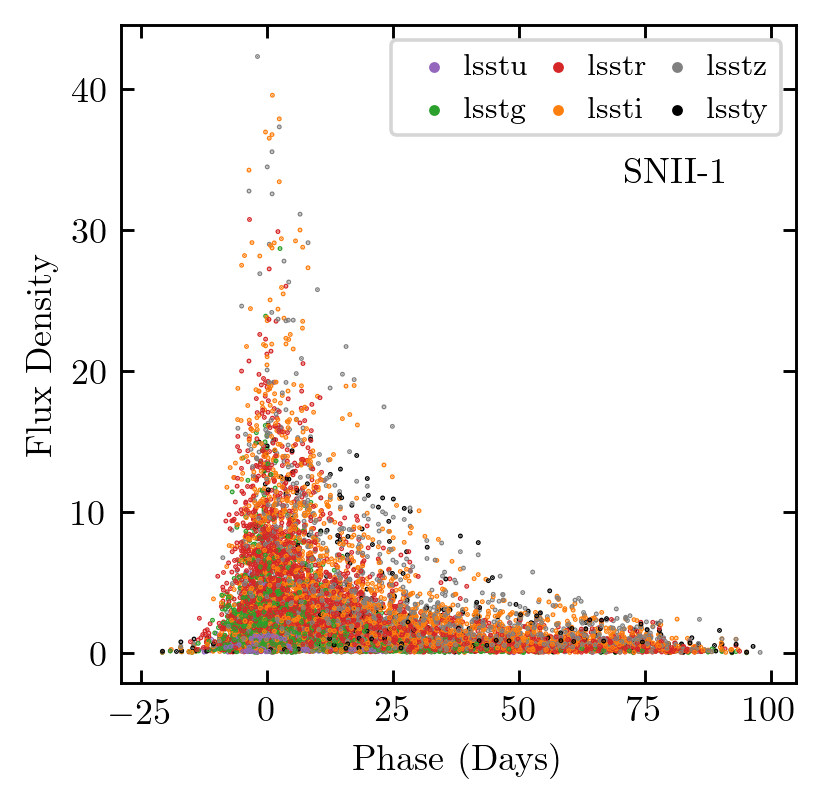

In [63]:
plot_photometry('SNII-1')

In [37]:
learn_lc('SNII-1', tstep=4, w=3)

SNII-1
The following training sets are empty:[-24]
Removing those time slices
mse0: 112085.00
msef: 49650.04
dmse: -0.56


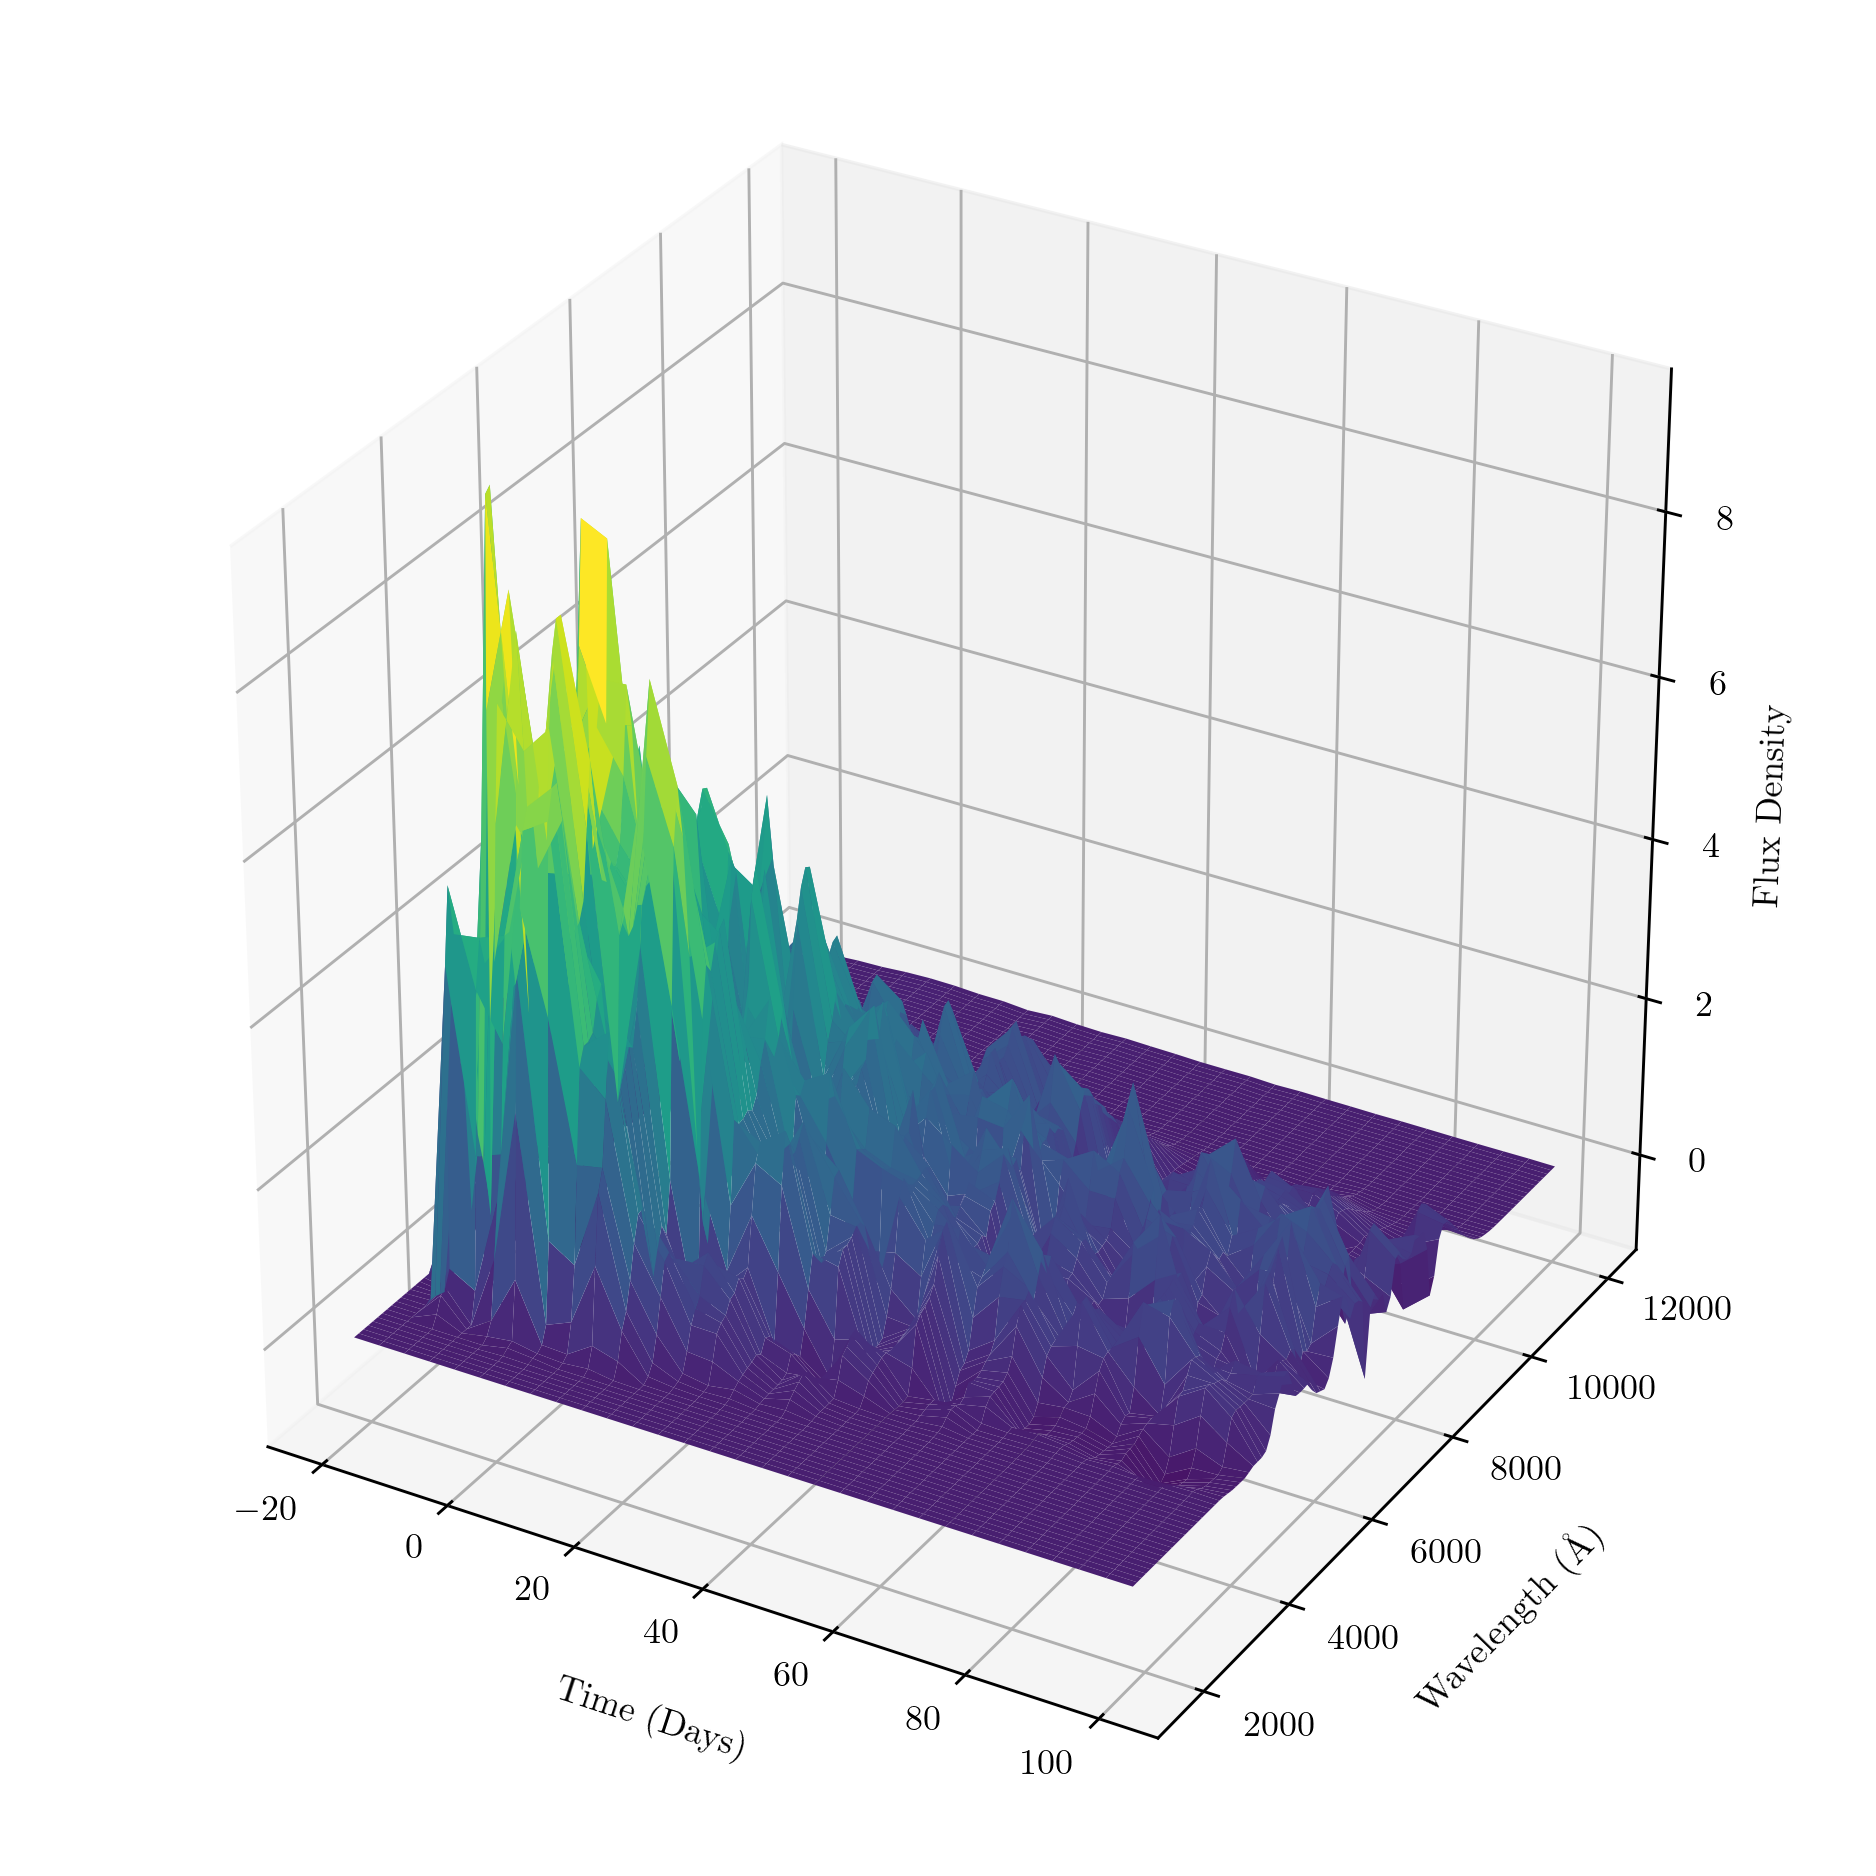

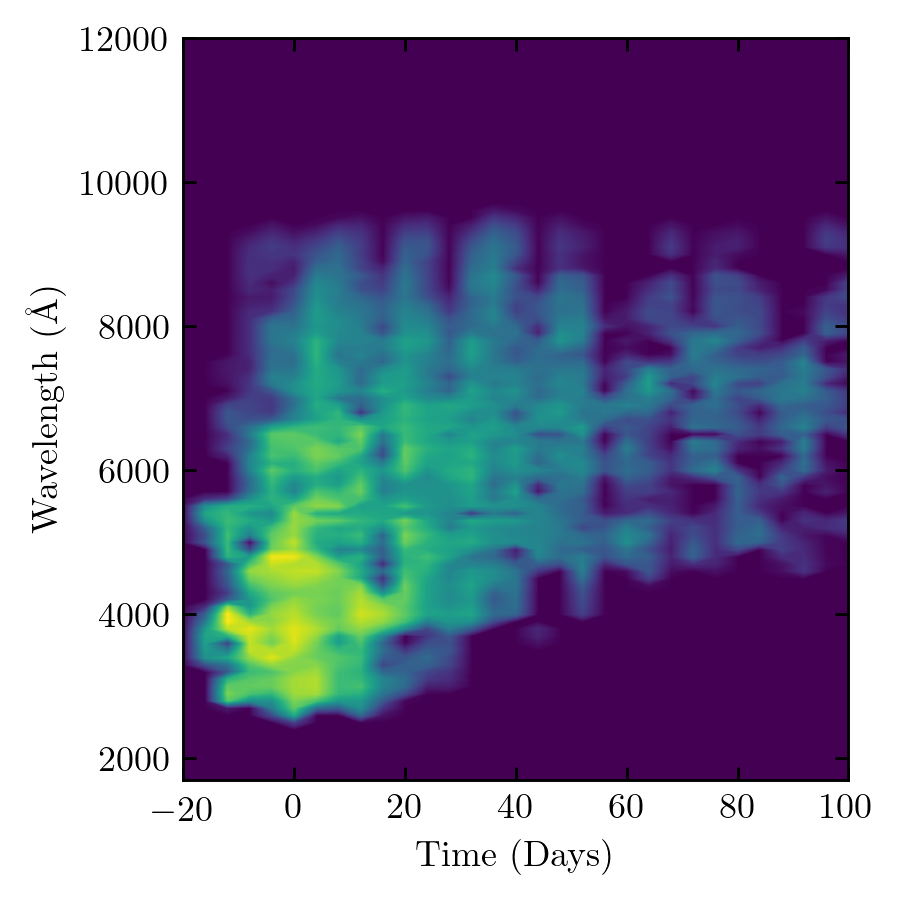

In [38]:
lc = lc_dict['SNII-1']
lc.surface_plot()
lc.contour_plot()
plt.show()

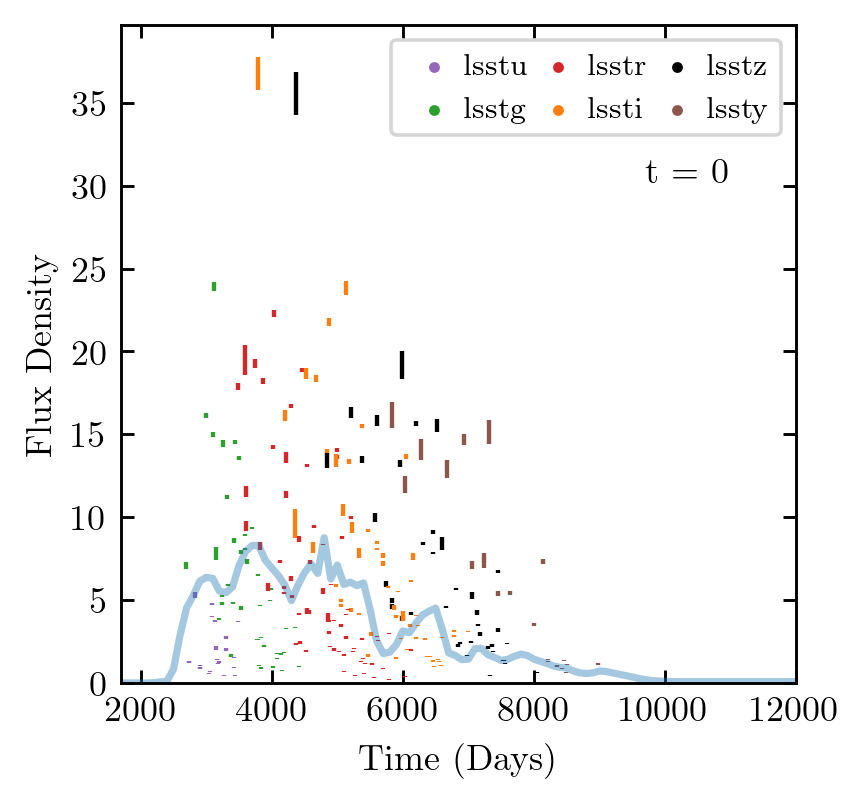

In [39]:
plot_trained_tslice('SNII-1', 0)

### SNII-3 (SNII-MOSFIT)

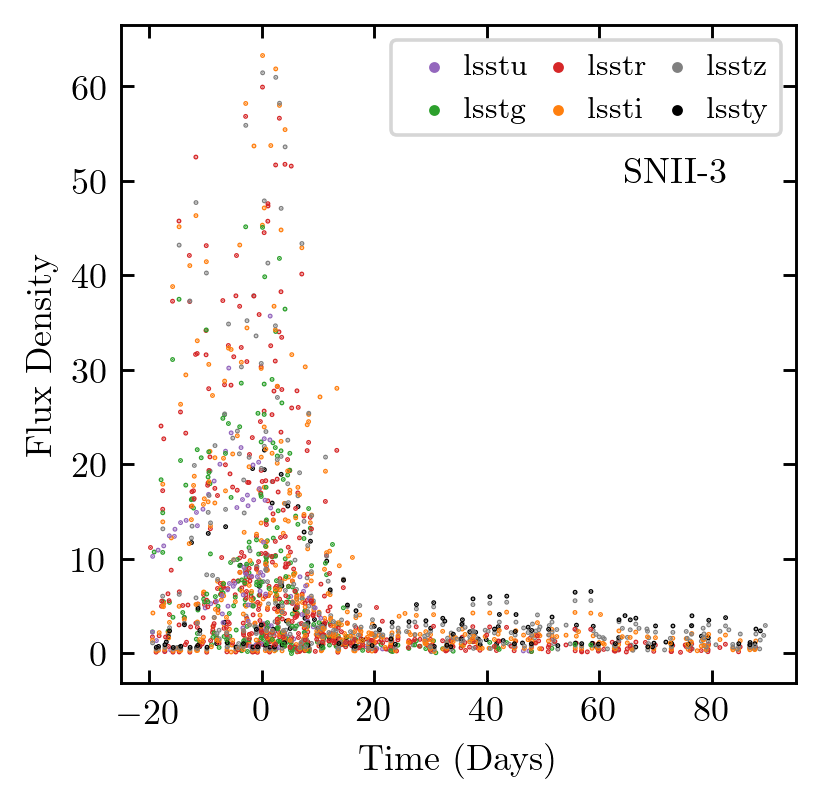

In [63]:
plot_photometry('SNII-3')

In [67]:
learn_lc('SNII-3', tstep=4, w=3)

SNII-3
The following training sets are empty:[92]
Removing those time slices
mse0: 672329.32
msef: 117091.15
dmse: -0.83


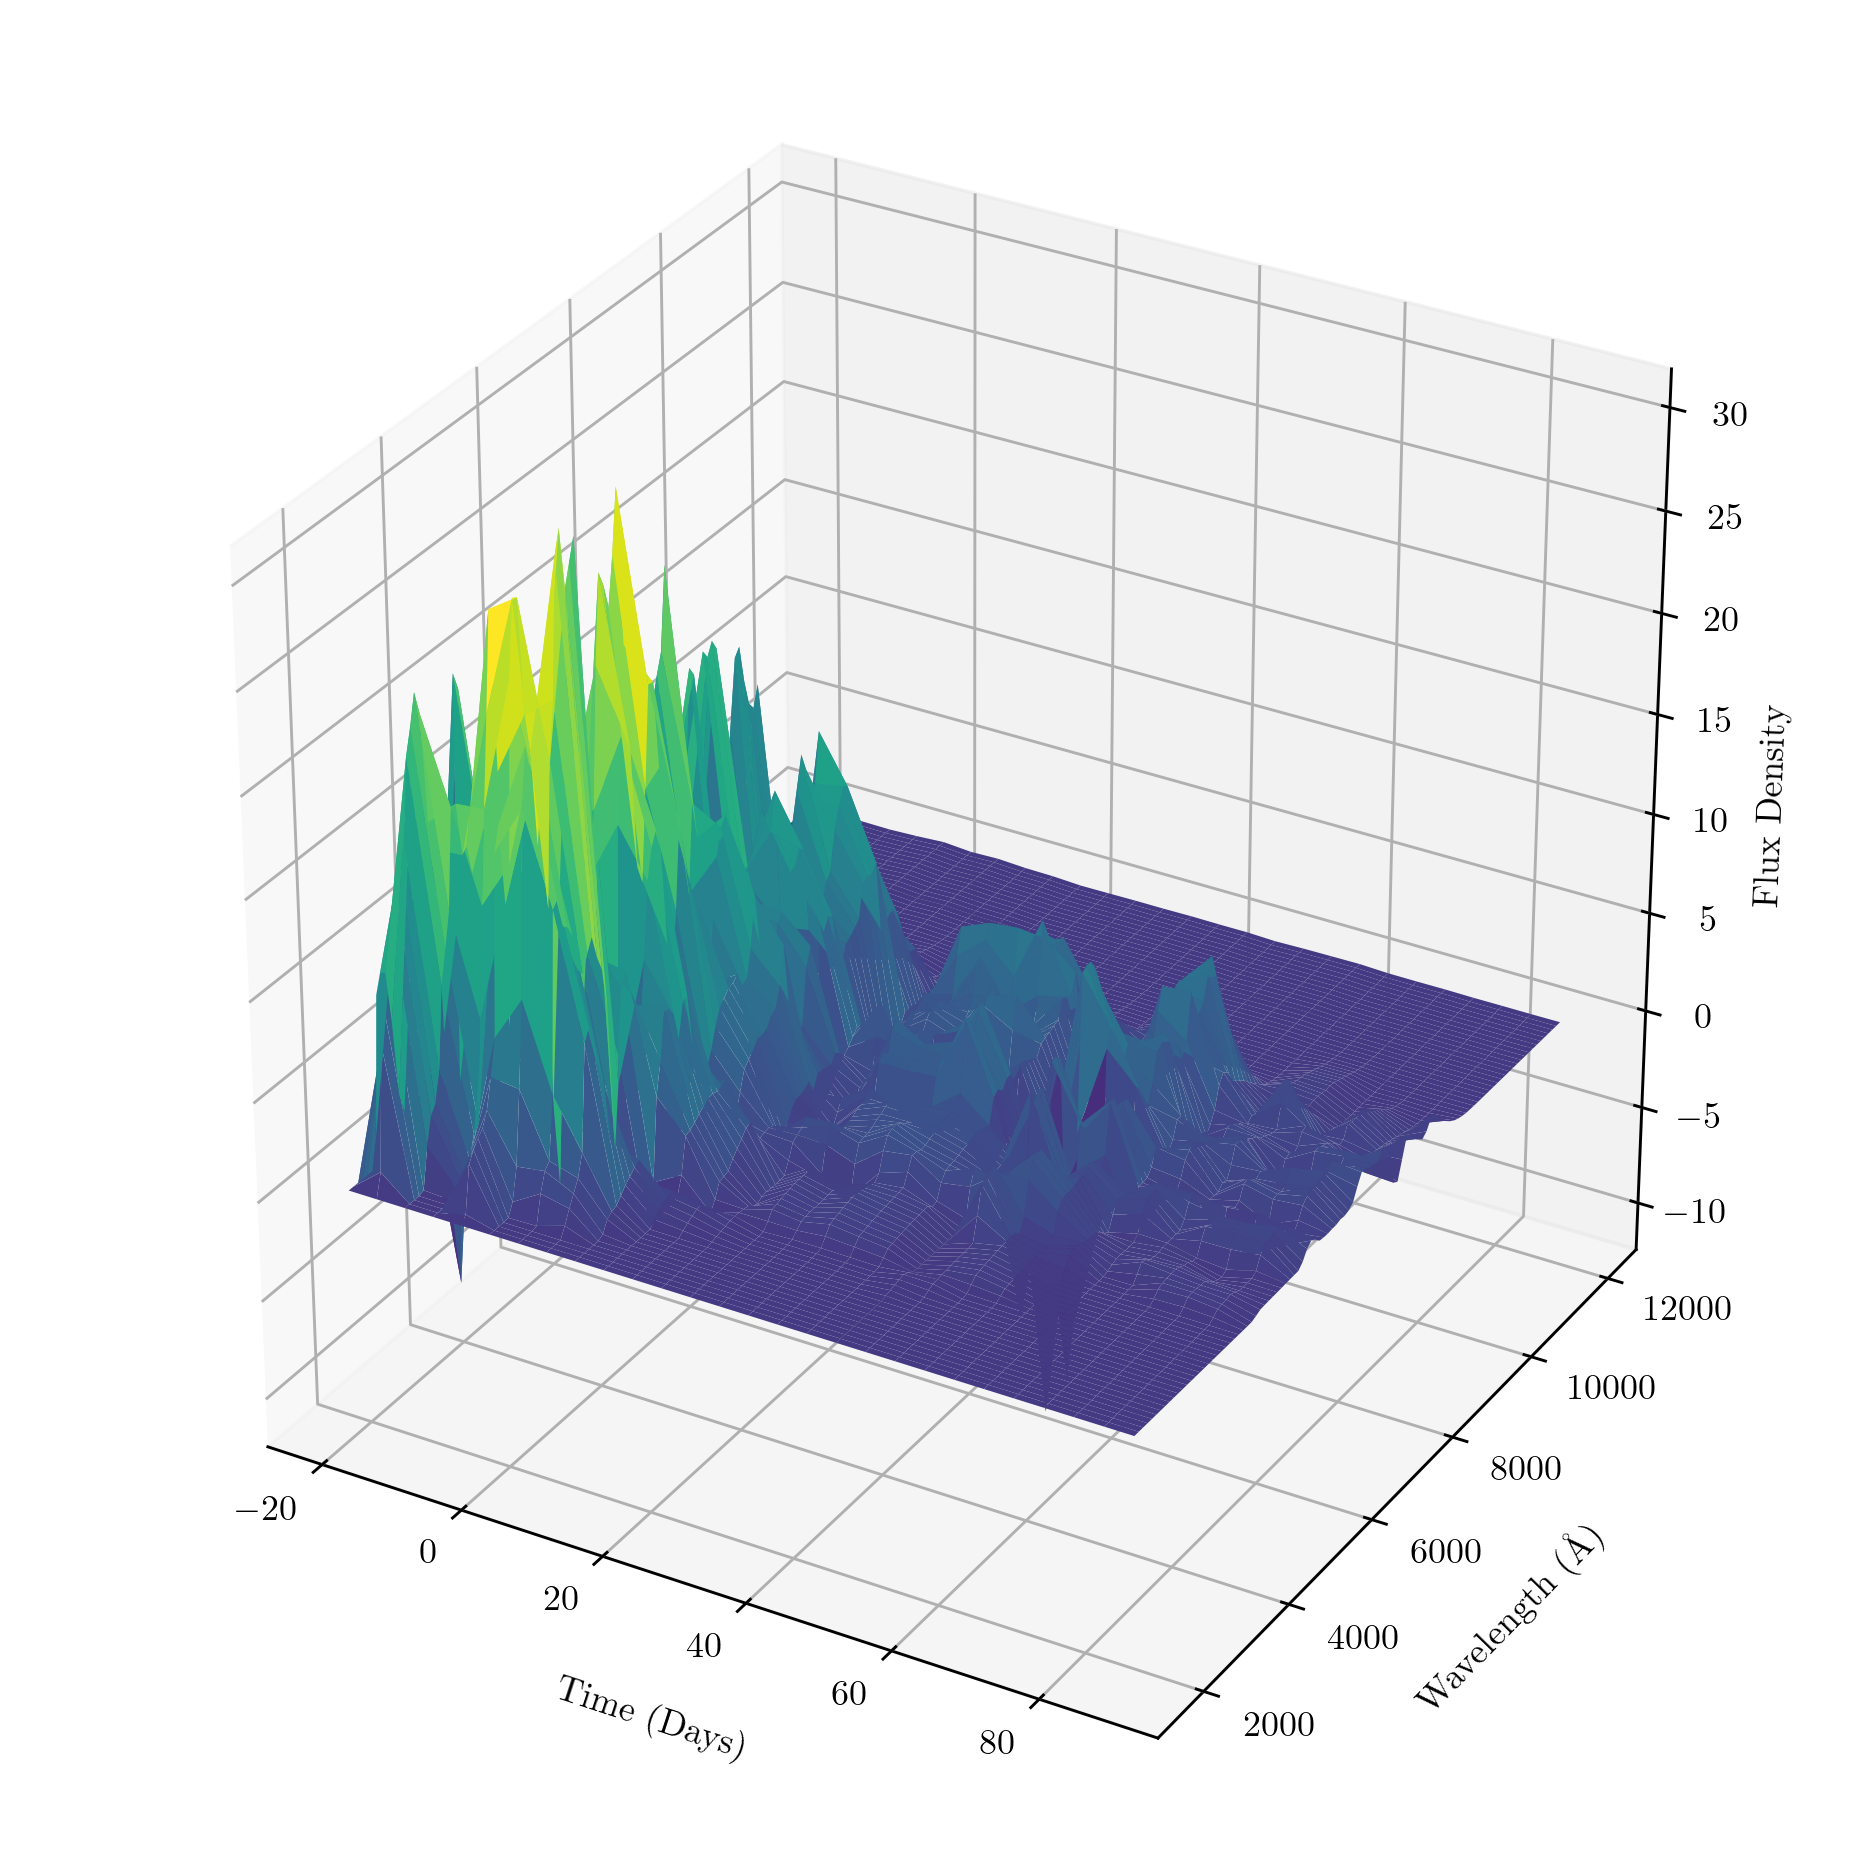

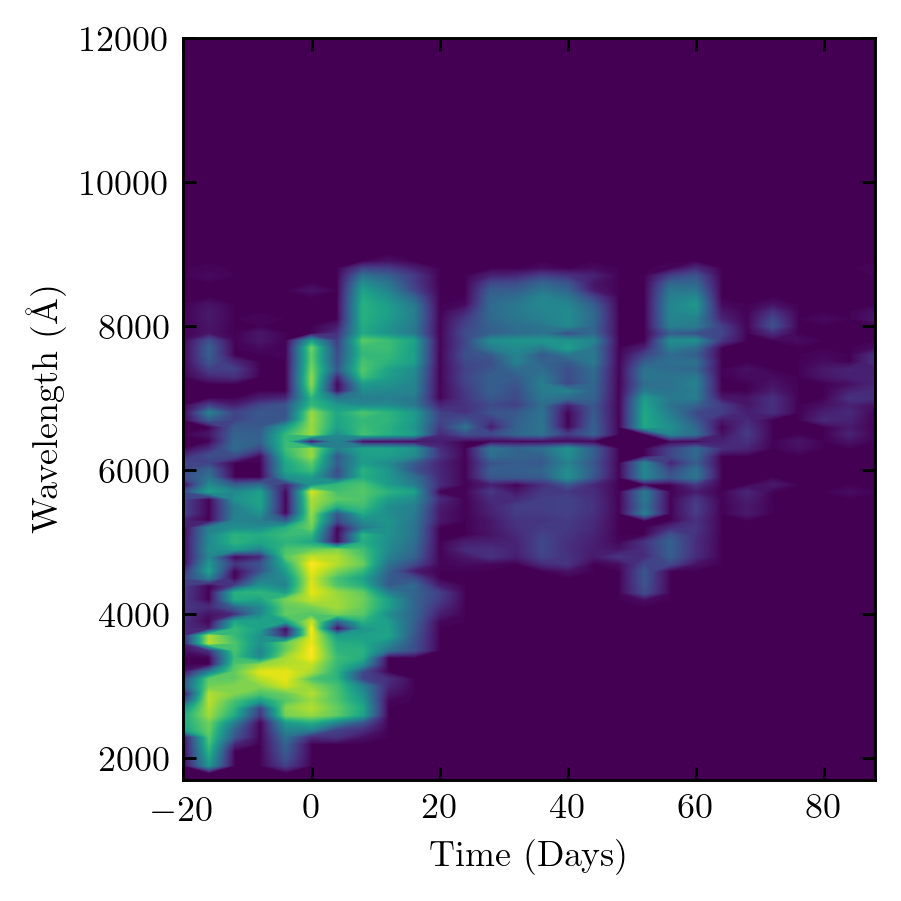

In [68]:
lc = lc_dict['SNII-3']
lc.surface_plot()
lc.contour_plot()
plt.show()

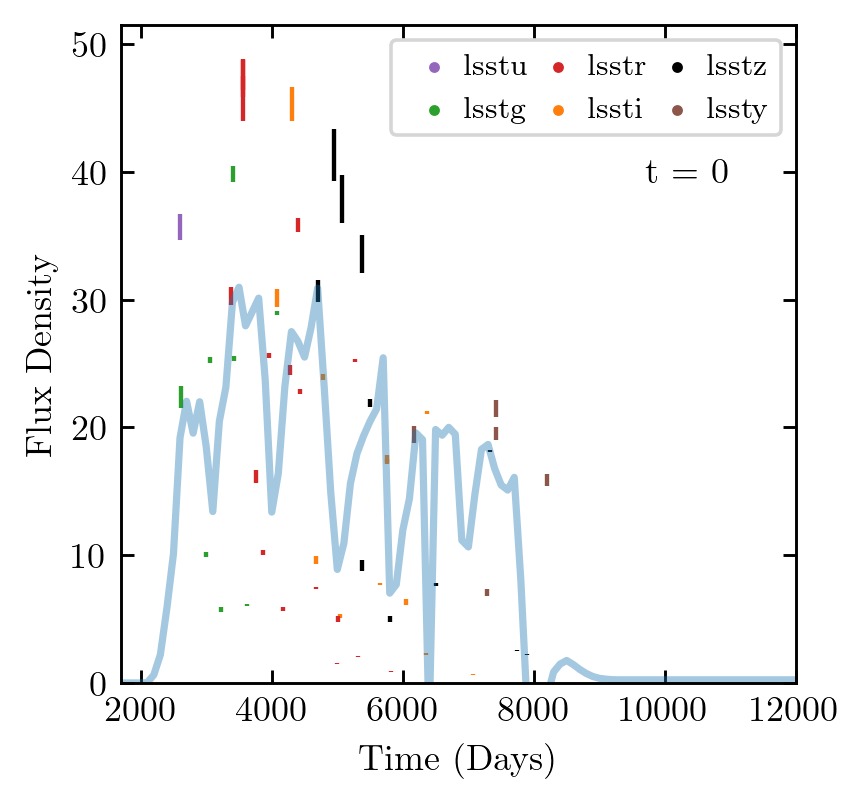

In [69]:
plot_trained_tslice('SNII-3', 0)